In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

classifiers = {
    'kNN': KNeighborsClassifier(n_neighbors=11),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data

def load_data_to_df():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    images = df_data.to_numpy()
    correct_images = [im.reshape(64, 64).T for im in images]
    correct_images = np.array(correct_images)
    flattened_correct_images = [im.flatten() for im in correct_images]
    df = pd.DataFrame(flattened_correct_images)
    df["Label"] = df_labels
    
    return df

def rotate_images(df):
    indices_to_rotate = np.random.choice(df.index, len(df) // 2, replace=False)
   # Work only with the image data (assuming 'Label' is the last column)
    image_data = df.drop('Label', axis=1)
    images = image_data.to_numpy()
       # Rotate selected images by 180 degrees
    for index in indices_to_rotate:
        images[index] = np.rot90(images[index].reshape(64, 64), 2).flatten()  # Rotate and flatten the image


    # Reconstruct the DataFrame
    rotated_df = pd.DataFrame(images, columns=df.columns[:-1])
    rotated_df['Label'] = df['Label']  # Reattach the label
    return rotated_df


### Comment: 
#Clearly the classification drops in performance ove tests with rotated images.
#This is expected as the model has not been trained on rotated images.



In [55]:
#Just loading and rotating images.
# Load and rotate images
df = load_data_to_df()
df = rotate_images(df)
"""
# Sample four random images from the DataFrame
sampled_images = df.sample(4)
# Set up the figure and axes for a 2x2 grid of images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = axes.ravel()  # Flatten the array of axes

# Loop over the randomly sampled images and plot each one
for i, (idx, row) in enumerate(sampled_images.iterrows()):
    image = row.drop('Label').values.reshape(64, 64) 
    axes[i].imshow(image, cmap='gray')  
    axes[i].set_title(f"Image {idx}") 
    axes[i].axis('off')  

plt.tight_layout()
plt.show()  
"""



'\n# Sample four random images from the DataFrame\nsampled_images = df.sample(4)\n# Set up the figure and axes for a 2x2 grid of images\nfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))\naxes = axes.ravel()  # Flatten the array of axes\n\n# Loop over the randomly sampled images and plot each one\nfor i, (idx, row) in enumerate(sampled_images.iterrows()):\n    image = row.drop(\'Label\').values.reshape(64, 64) \n    axes[i].imshow(image, cmap=\'gray\')  \n    axes[i].set_title(f"Image {idx}") \n    axes[i].axis(\'off\')  \n\nplt.tight_layout()\nplt.show()  \n'

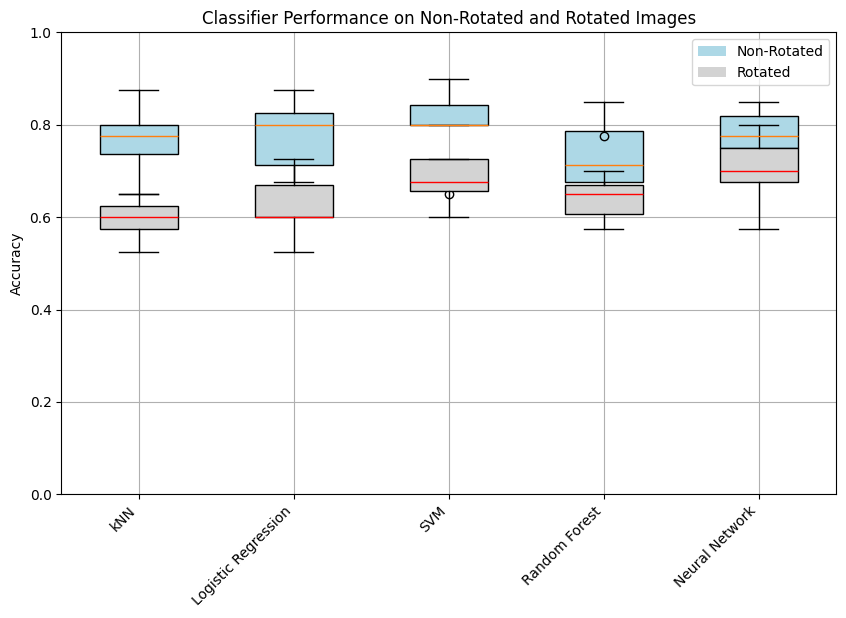

In [56]:
#Train on rotated images
X = df.drop('Label', axis=1).values  # Feature set
y = df['Label'].values  # Labels
misclassified_info = {}
results_rotated = {}
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_scaled, X_test_scaled = standardize(X_train, X_test)   #Mind: no 


    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train.ravel())
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        if name not in results_rotated.keys():
            results_rotated[name] = []
        results_rotated[name].append(accuracy)

        #cross_val_acc = cross_val_score(clf, X, y, cv=5)  # 5-fold cross-validation
        #print(f"{name} test accuracy: {accuracy:.2f}, Cross-validated accuracy: {np.mean(cross_val_acc):.2f}")

#Train on non-rotated images
df = load_data_to_df()
X = df.drop('Label', axis=1).values  # Feature set
y = df['Label'].values  # Labels
results = {}
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_scaled, X_test_scaled = standardize(X_train, X_test)   #Mind: no

    for name,clf in classifiers.items():
        clf.fit(X_train_scaled, y_train.ravel())
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        if name not in results.keys():
            results[name] = []
        results[name].append(accuracy)

        #cross_val_acc = cross_val_score(clf, X, y, cv=5)
        #print(f"{name} test accuracy: {accuracy:.2f}, Cross-validated accuracy: {np.mean(cross_val_acc):.2f}")

# Create DataFrame for box plot non-rotated
df = pd.DataFrame(results.items(), columns=['Classifier', 'Accuracy'])
#Create DataFrame for box plot rotated
df_rotated = pd.DataFrame(results_rotated.items(), columns=['Classifier', 'Accuracy'])

#Create box plot:

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(df['Accuracy'], patch_artist=True,boxprops=dict(facecolor='lightblue'))
plt.boxplot(df_rotated['Accuracy'], patch_artist=True,boxprops=dict(facecolor='lightgrey'),medianprops=dict(color='red'))
plt.xticks([i+1 for i in range(len(df))], df['Classifier'], rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Classifier Performance on Non-Rotated and Rotated Images')
# Creating custom legends
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', label='Non-Rotated'),
                   Patch(facecolor='lightgrey', label='Rotated')]
plt.legend(handles=legend_elements, loc='best')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()






Number of important features Log Reg: 1718


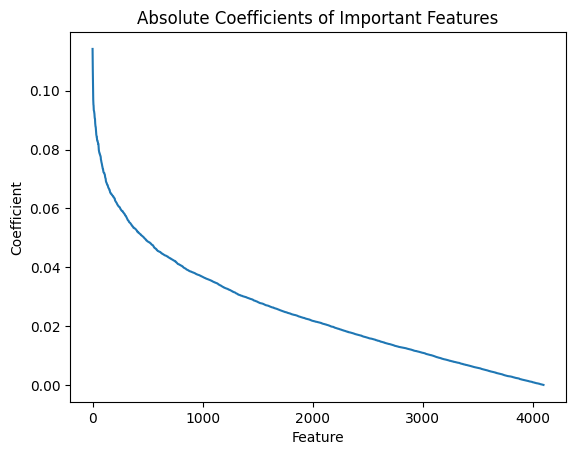

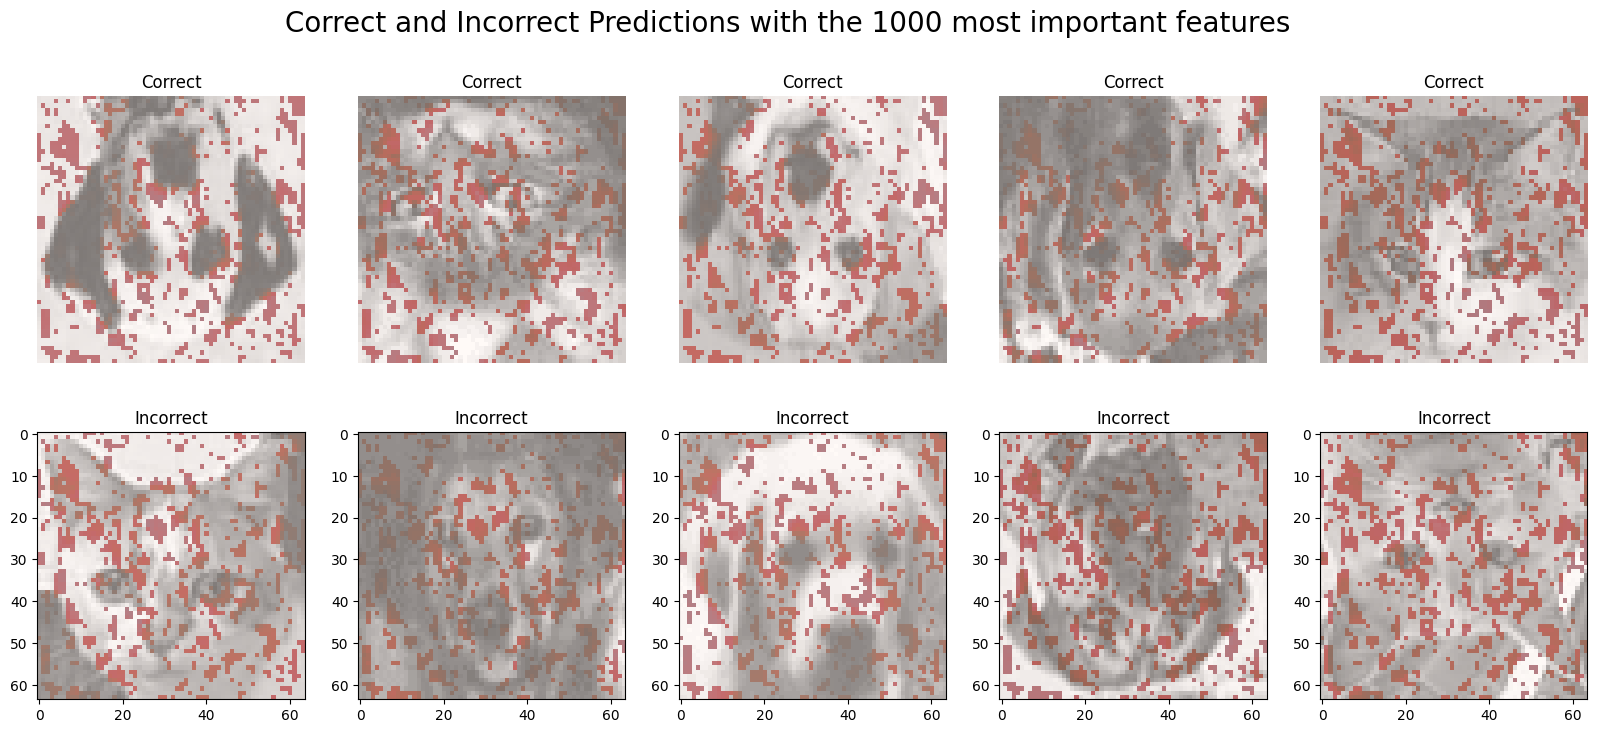

In [57]:
#LOG REG:
df = load_data_to_df()
df = rotate_images(df)
images = df.drop('Label', axis=1)
labels = df['Label']
images_rotated = images.copy()


X_train, X_test, y_train, y_test = train_test_split(images_rotated, labels, test_size=0.2, random_state=42)
X_test_unscaled = X_test.copy().values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#LOG REG MODEL:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

from sklearn.feature_selection import SelectFromModel

feature_selector = SelectFromModel(lr_model, threshold='mean')
feature_selector.fit(X_train, y_train)
lr_important_features = np.where(feature_selector.get_support())[0]
lr_coefficients = lr_model.coef_[0]
lr_important_feature_coeffs = lr_coefficients[lr_important_features]
lr_ranked_features = lr_important_features[np.argsort(-np.abs(lr_important_feature_coeffs))]
lr_y_pred = lr_model.predict(X_test)
lr_correct_indices = np.where(lr_y_pred == y_test)[0]
lr_incorrect_indices = np.where(lr_y_pred != y_test)[0]
lr_correct_sample_indices = np.random.choice(lr_correct_indices, 5, replace=False)
lr_incorrect_sample_indices = np.random.choice(lr_incorrect_indices, 5, replace=False)
print(f"Number of important features Log Reg: {len(lr_important_features)}")

# Plot a line graph of the absolute coefficients of the important features

# Get the list of the most important coefficients
lr_important_coefficients = lr_coefficients[lr_important_features]
lr_important_coefficients = np.abs(lr_important_coefficients)
lr_important_coefficients.sort()
lr_important_coefficients = lr_important_coefficients[::-1]  # Sort in descending order

lr_coefficients = np.abs(lr_coefficients)
lr_coefficients.sort()

# Plot the coefficients
plt.plot(lr_coefficients[::-1])
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("Absolute Coefficients of Important Features")
plt.show()


feature_threshold = 1000

fix, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(lr_correct_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[0, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[0, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[0, i].set_title(f"Correct")
    axes[0, i].axis("off")

for i, idx in enumerate(lr_incorrect_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[1, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[1, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[1, i].set_title(f"Incorrect")
    axes[0, i].axis("off")

plt.suptitle(
    f"Correct and Incorrect Predictions with the {feature_threshold} most important features",
    fontsize=20,
)
plt.show()


Number of important features: 1740


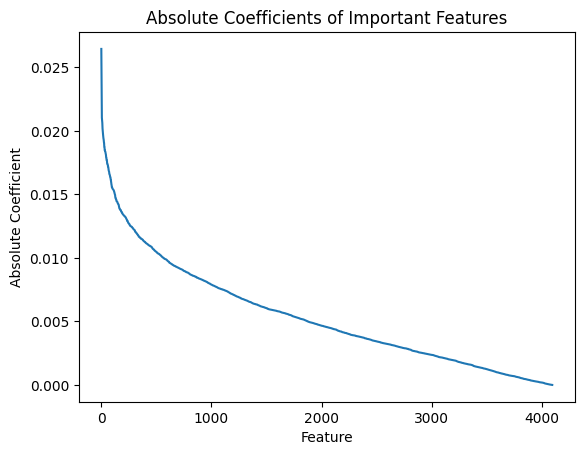

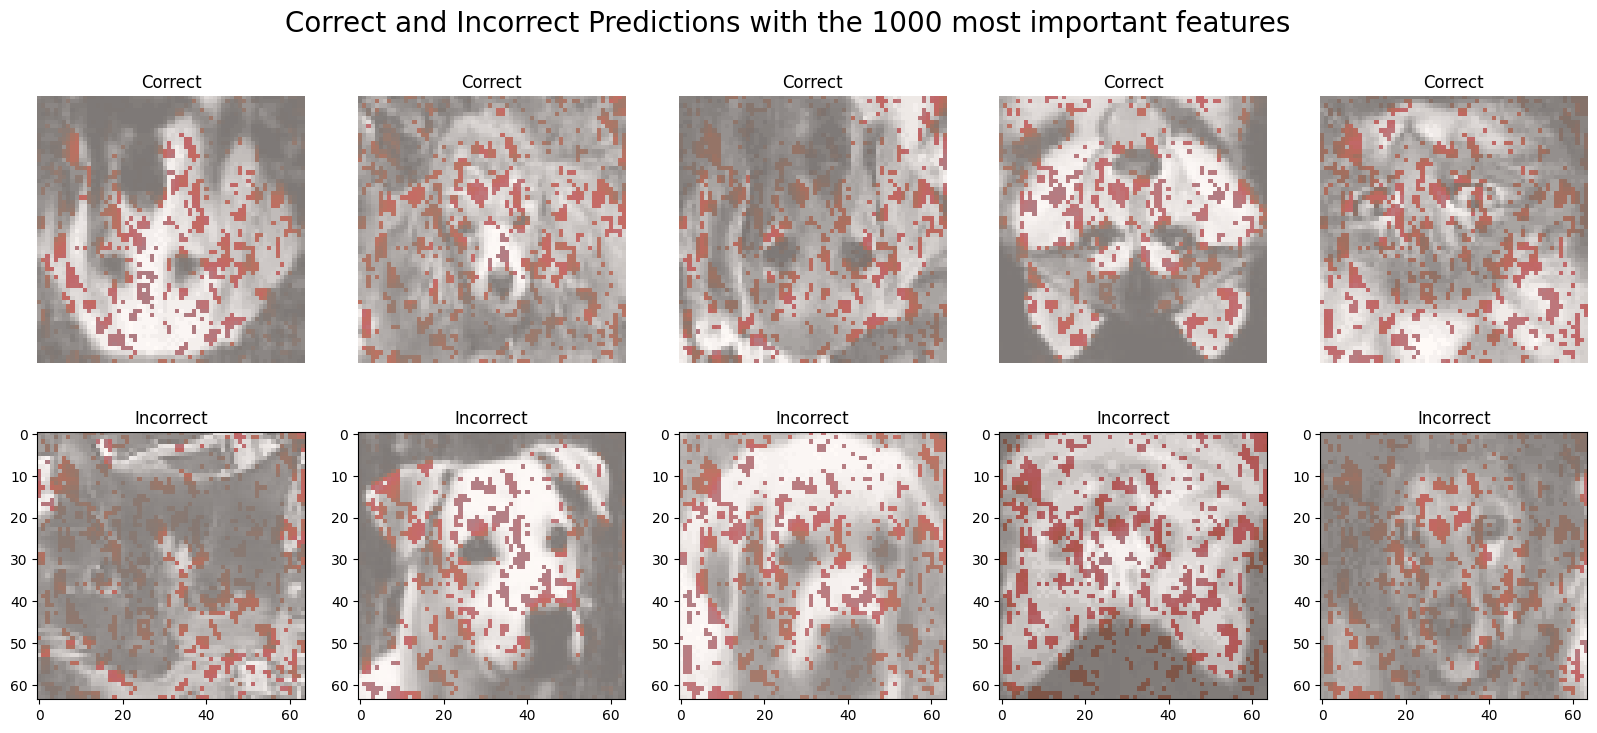

In [58]:
#SVM:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train.values.ravel())

feature_selector = SelectFromModel(svm, threshold='mean')
feature_selector.fit(X_train, y_train)
svm_important_features = np.where(feature_selector.get_support())[0]
svm_important_features = svm_important_features.reshape(-1)

svm_coefs = svm.coef_
svm_abs_coefs = np.abs(svm_coefs)
# svm_important_features = np.argsort(svm_abs_coefs)[::-1]
# svm_important_features = svm_important_features.reshape(-1)
svm_y_pred = svm.predict(X_test)
svm_correct_indices = np.where(svm_y_pred == y_test)[0]
svm_incorrect_indices = np.where(svm_y_pred != y_test)[0]
svm_correct_sample_indices = np.random.choice(svm_correct_indices, 5, replace=False)
svm_incorrect_sample_indices = np.random.choice(svm_incorrect_indices, 5, replace=False)
print(f"Number of important features: {len(svm_important_features)}")
svm_abs_coefs[0].sort()
plt.plot(svm_abs_coefs[0][::-1])
plt.title("Absolute Coefficients of Important Features")
plt.xlabel("Feature")
plt.ylabel("Absolute Coefficient")
plt.show()

_, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(svm_correct_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[0, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[0, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[0, i].set_title(f"Correct")
    axes[0, i].axis("off")

for i, idx in enumerate(svm_incorrect_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[1, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[1, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[1, i].set_title(f"Incorrect")
    axes[0, i].axis("off")

plt.suptitle(
    f"Correct and Incorrect Predictions with the {feature_threshold} most important features",
    fontsize=20,
)
plt.show()

Number of important features: 4096


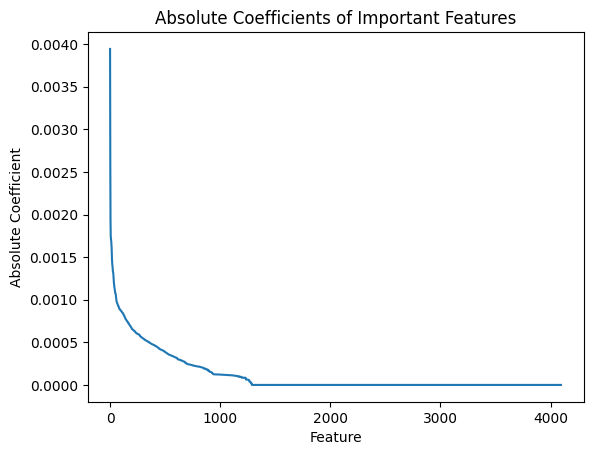

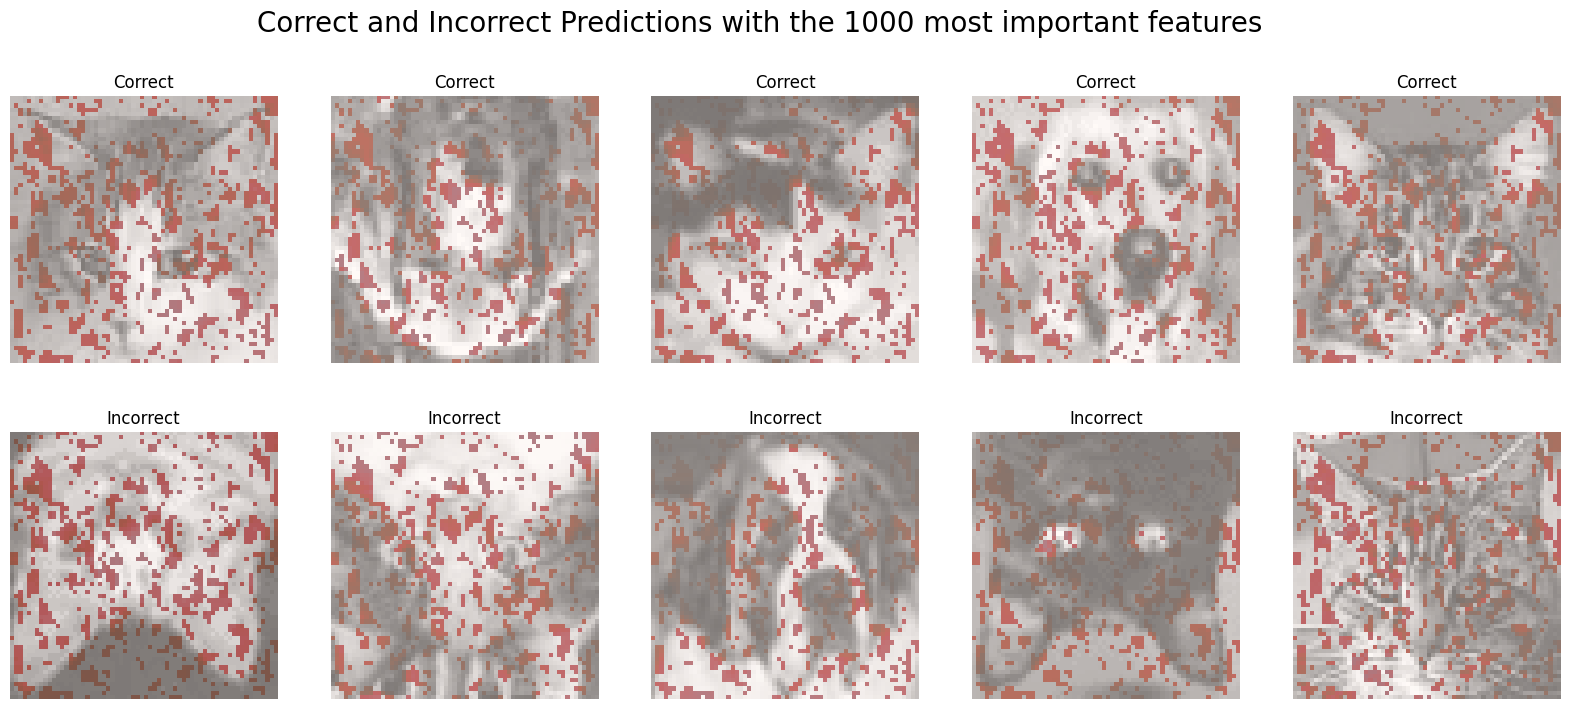

In [59]:
#RF:
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

# Extract feature importance from tree splits
rf_feature_importance = np.zeros(images.shape[1])
for tree in rf.estimators_:
    tree_feature_importance = tree.tree_.compute_feature_importances(normalize=False)
    rf_feature_importance += tree_feature_importance

# Normalize feature importance across trees
rf_feature_importance /= len(rf.estimators_)
rf_important_features = np.argsort(rf_feature_importance)[::-1]
print(f"Number of important features: {len(rf_important_features)}")
rf_y_pred = rf.predict(X_test)
rf_correct_indices = np.where(rf_y_pred == y_test)[0]
rf_incorrect_indices = np.where(rf_y_pred != y_test)[0]
rf_correct_sample_indices = np.random.choice(rf_correct_indices, 5, replace=False)
rf_incorrect_sample_indices = np.random.choice(rf_incorrect_indices, 5, replace=False)
rf_feature_importance.sort()
plt.plot(rf_feature_importance[::-1])
plt.title("Absolute Coefficients of Important Features")
plt.xlabel("Feature")
plt.ylabel("Absolute Coefficient")
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(rf_correct_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[0, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[0, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[0, i].set_title(f"Correct")
    axes[0, i].axis("off")

for i, idx in enumerate(rf_incorrect_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[1, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[1, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[1, i].set_title(f"Incorrect")
    axes[1, i].axis("off")

plt.suptitle(
    f"Correct and Incorrect Predictions with the {feature_threshold} most important features",
    fontsize=20,
)
plt.show()

Accuracy: 0.68
Number of misclassified images: 13


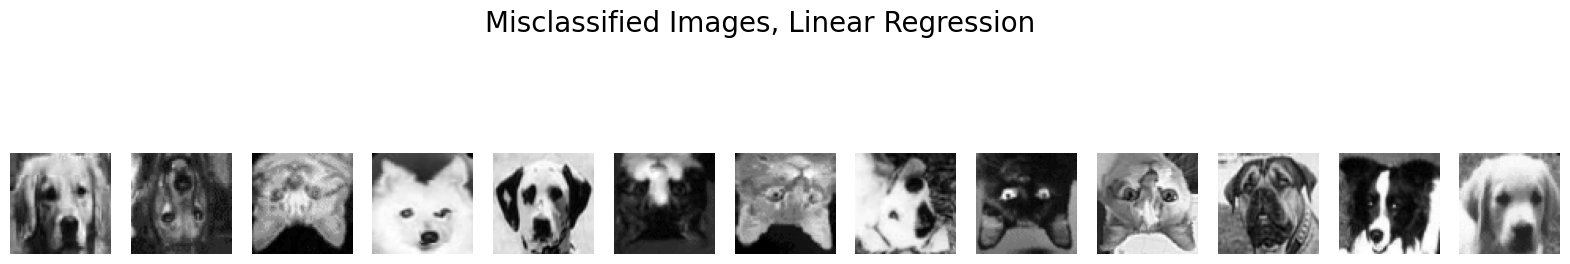

In [60]:
#Are upside-down images overrepresented among misclassified images?
#prediction: yes, but not as much as one might think.
# Load and rotate images
df = load_data_to_df()
df = rotate_images(df)
images = df.drop('Label', axis=1)
labels = df['Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_test_unscaled = X_test.copy().values  # Keep unscaled data for visualization

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy (optional, for your reference)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Identify misclassified images
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")
misclass_idx=len(misclassified_indices)



# Visualize misclassified images
fig, axes = plt.subplots(1, misclass_idx, figsize=(20, 4))  # Adjust the subplot grid as needed
for i, idx in enumerate(misclassified_indices[:misclass_idx]):  # Show up to 5 misclassified images
    image = X_test_unscaled[idx].reshape(64, 64)  # Adjust shape depending on your actual image shape
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")

plt.suptitle("Misclassified Images, Linear Regression", fontsize=20)
plt.show()


Accuracy: 0.72
Number of misclassified images: 11


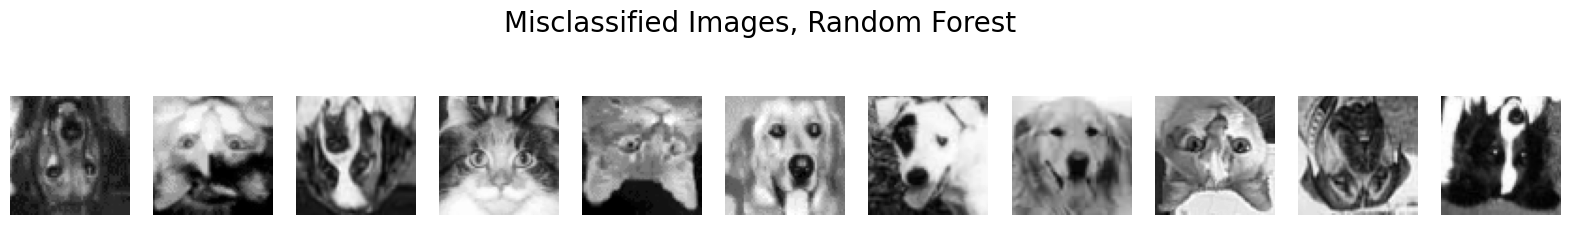

In [61]:
#Are upside-down images overrepresented among misclassified images?
#prediction: yes, but not as much as one might think.
# Load and rotate images
df = load_data_to_df()
df = rotate_images(df)
images = df.drop('Label', axis=1)
labels = df['Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_test_unscaled = X_test.copy().values  # Keep unscaled data for visualization

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy (optional, for your reference)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Identify misclassified images
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")
misclass_idx=len(misclassified_indices)
# Visualize misclassified images
fig, axes = plt.subplots(1, misclass_idx, figsize=(20, 3))  # Adjust the subplot grid as needed
for i, idx in enumerate(misclassified_indices[:misclass_idx]):  # Show up to 5 misclassified images
    image = X_test_unscaled[idx].reshape(64, 64)  # Adjust shape depending on your actual image shape
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")

plt.suptitle("Misclassified Images, Random Forest", fontsize=20)
plt.show()


Accuracy: 0.78
Number of misclassified images: 9
0.225


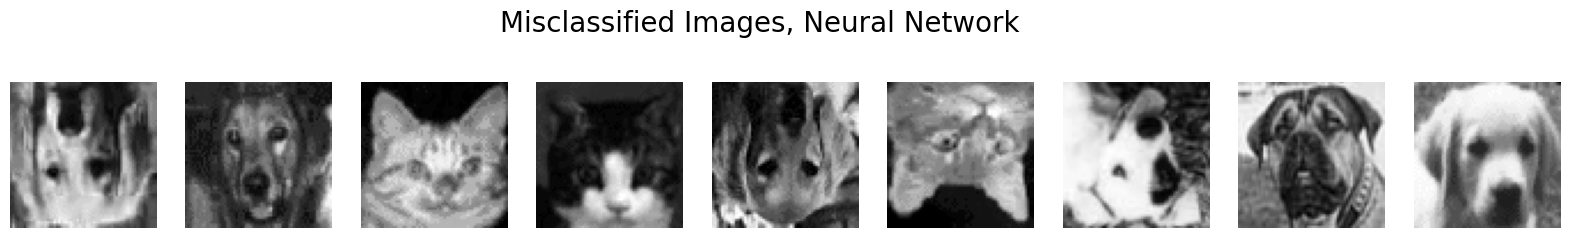

In [62]:
#Are upside-down images overrepresented among misclassified images?
#prediction: yes, but not as much as one might think.
# Load and rotate images
df = load_data_to_df()
df = rotate_images(df)
images = df.drop('Label', axis=1)
labels = df['Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_test_unscaled = X_test.copy().values  # Keep unscaled data for visualization

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
clf = MLPClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy (optional, for your reference)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Identify misclassified images
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")
misclass_idx=len(misclassified_indices)
print(len(misclassified_indices)/len(y_test))

# Visualize misclassified images
fig, axes = plt.subplots(1, misclass_idx, figsize=(20, 3))  # Adjust the subplot grid as needed
for i, idx in enumerate(misclassified_indices[:misclass_idx]):  # Show up to 5 misclassified images
    image = X_test_unscaled[idx].reshape(64, 64)  # Adjust shape depending on your actual image shape
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")

plt.suptitle("Misclassified Images, Neural Network", fontsize=20)
plt.show()
